<a href="https://colab.research.google.com/github/Ankur7470/nlp-assignment2/blob/main/A2_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
!pip install nltk

## Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## EDA

### Loading the Sentiment Analysis Dataset

In [ ]:
sentiment_data = pd.read_csv("sentimentdataset.csv")

### Information about the Dataset

In [ ]:
sentiment_data.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [ ]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [ ]:
sentiment_data = sentiment_data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour'])

### Working with Sentiment Labels

In [ ]:
print("\nNo. of Unique Sentiments:", sentiment_data['Sentiment'].nunique())


No. of Unique Sentiments: 279


In [ ]:
sentiment_data['Sentiment'].unique()

array([' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ',
       ' Fear         ', ' Sadness      ', ' Disgust      ',
       ' Happiness    ', ' Joy          ', ' Love         ',
       ' Amusement    ', ' Enjoyment    ', ' Admiration   ',
       ' Affection    ', ' Awe          ', ' Disappointed ',
       ' Surprise     ', ' Acceptance   ', ' Adoration    ',
       ' Anticipation ', ' Bitter       ', ' Calmness     ',
       ' Confusion    ', ' Excitement   ', ' Kind         ',
       ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ',
       ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ',
       ' Serenity      ', ' Gratitude     ', ' Hope          ',
       ' Empowerment   ', ' Compassion    ', ' Tenderness    ',
       ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ',
       ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ',
       ' Elation   ', ' Despair         ', ' Grief           ',
       ' Loneliness     

In [ ]:
# Stripping the leading and trailing spaces from each sentiment
sentiment_data['Sentiment'] = [sentiment.strip() for sentiment in sentiment_data['Sentiment']]

In [ ]:
print("\nNo. of Unique Sentiments after stripping the unwanted spaces from sentiment labels :", sentiment_data['Sentiment'].nunique())


No. of Unique Sentiments after stripping the unwanted spaces from sentiment labels : 191


In [ ]:
sentiment_counts = sentiment_data['Sentiment'].value_counts()
print("Sentiment Counts:\n")
sentiment_counts[:10]

Sentiment Counts:



,count
Sentiment,
Positive,45
Joy,44
Excitement,37
Contentment,19
Neutral,18
Gratitude,18
Curiosity,16
Serenity,15
Happy,14


### Checking for Duplicate Text Entries

In [ ]:
print("No. of Duplicate Text Entries", sentiment_data['Text'].duplicated().sum())

No. of Duplicate Text Entries 25


In [ ]:
# Filtering texts that appear more than once
duplicate_texts = sentiment_data.groupby('Text').size().reset_index(name='count')
duplicate_texts[duplicate_texts['count'] > 1]

,Text,count
1,"A compassionate rain, tears of empathy fallin...",3
4,"A free spirit soaring on the wings of dreams,...",2
12,"A playful escapade in the carnival of life, c...",3
40,"Bathed in the golden hues of gratefulness, a ...",2
52,Charting a course through the waves of hopefu...,2
59,"Confident strides in the dance of life, a bal...",2
81,"Dismissive gestures, a curtain drawn to shiel...",2
93,"Embraced by the hopeful dawn, a gardener sowi...",3
148,"Floating on clouds of inspiration, an artist ...",2
176,"Hopeful whispers of wind, carrying the promis...",2


### Handling Duplicate Text Entries

In [ ]:
# Keeping the first occurrence of each duplicate
sentiment_data = sentiment_data.drop_duplicates(subset=['Text'], keep='first')

In [ ]:
print("No. of Duplicate Text Entries (keeping only the first occurrence): ", sentiment_data['Text'].duplicated().sum())

No. of Duplicate Text Entries (keeping only the first occurrence):  0


In [ ]:
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 731
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       707 non-null    object
 1   Sentiment  707 non-null    object
dtypes: object(2)
memory usage: 16.6+ KB


## Data Preprocessing

### Applying Preprocessing to all the texts

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

sentiment_data['Tokenized Text'] = [preprocess_text(text) for text in sentiment_data['Text'].values]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Dataset after Preprocessing/Tokenization of texts

In [ ]:
sentiment_data.head(10)

,Text,Sentiment,Tokenized Text
0,Enjoying a beautiful day at the park! ...,Positive,"[enjoying, beautiful, day, park]"
1,Traffic was terrible this morning. ...,Negative,"[traffic, terrible, morning]"
2,Just finished an amazing workout! 💪 ...,Positive,"[finished, amazing, workout]"
3,Excited about the upcoming weekend getaway! ...,Positive,"[excited, upcoming, weekend, getaway]"
4,Trying out a new recipe for dinner tonight. ...,Neutral,"[trying, new, recipe, dinner, tonight]"
5,Feeling grateful for the little things in lif...,Positive,"[feeling, grateful, little, thing, life]"
6,Rainy days call for cozy blankets and hot coc...,Positive,"[rainy, day, call, cozy, blanket, hot, cocoa]"
7,The new movie release is a must-watch! ...,Positive,"[new, movie, release, mustwatch]"
8,Political discussions heating up on the timel...,Negative,"[political, discussion, heating, timeline]"
9,Missing summer vibes and beach days. ...,Neutral,"[missing, summer, vibe, beach, day]"


### Handling the High No. of Sentiments

In [ ]:
positive = {
    "Acceptance", "Accomplishment", "Admiration", "Adoration", "Affection", "Amazement",
    "Appreciation", "Blessed", "Breakthrough", "Calmness", "Celebration", "Charm",
    "Compassion", "Confidence", "Contentment", "Creativity", "Curiosity", "Dazzle",
    "Determination", "Ecstasy", "Elation", "Elegance", "Empowerment", "Enchantment",
    "Engagement", "Enjoyment", "Enthusiasm", "Euphoria", "Excitement", "FestiveJoy",
    "Freedom", "Friendship", "Fulfillment", "Grateful", "Gratitude", "Happiness",
    "Happy", "Harmony", "Heartwarming", "Hope", "Hopeful", "Inspiration", "Inspired",
    "Joy", "Kindness", "Love", "Marvel", "Motivation", "Optimism", "Overjoyed",
    "Playful", "Positivity", "Pride", "Proud", "Radiance", "Rejuvenation", "Relief",
    "Resilience", "Romance", "Satisfaction", "Serenity", "Success", "Thrill",
    "Tranquility", "Triumph", "Vibrancy", "Wonder", "Wonderment", "Positive", "Amusement",
    "Awe", "Compassionate", "JoyfulReunion", "Colorful", "PlayfulJoy", "Confident",
    "Celestial Wonder", "Spark",  "Thrilling Journey", "Whimsy", "Touched",
    "Adrenaline", "Exploration", "Hypnotic", "Energy", "Tenderness",
    "Free-spirited", "Grandeur", "Zest", "Kind",
    "Adventure"
}

negative = {
    "Anger", "Anxiety", "Bad", "Betrayal", "Bitter", "Bitterness", "Bittersweet",
    "Darkness", "Desolation", "Despair", "Desperation", "Devastated", "Disappointed",
    "Disappointment", "Disgust", "Frustration", "Grief", "Hate", "Heartache",
    "Heartbreak", "Helplessness", "Intimidation", "Isolation", "Jealous", "Jealousy",
    "Loneliness", "Loss", "LostLove", "Melancholy",  "Numbness",
    "Overwhelmed", "Regret", "Resentment", "Ruins", "Sad", "Sadness", "Shame", "Sorrow",
    "Suffering",  "Sympathy",  "Fear", "Fearful", "Negative",
    "Mischievous", "Embarrassed", "Envy", "Envious", "Dismissive", "Frustrated",
    "Apprehensive", "Pensive", "Exhaustion", "Indifference", "Confusion", "Solace", "Suspense","Yearning"
}

neutral = {
    "Ambivalence", "Anticipation", "Arousal", "ArtisticBurst", "Boredom","Miscalculation",
    "Captivation", "Challenge", "Connection", "Contemplation", "Coziness",
    "Creative Inspiration", "Culinary Adventure", "CulinaryOdyssey", "Emotion",
    "EmotionalStorm", "Empathetic", "Envisioning History", "Iconic", "Immersion",
    "InnerJourney", "Journey", "Melodic", "Mesmerizing", "Mindfulness",
    "Nature's Beauty", "Neutral", "Nostalgia", "Obstacle", "Ocean's Freedom",
    "Pressure", "Reflection", "Renewed Effort", "Reverence", "Runway Creativity",
    "Serenity", "Solitude", "Surprise", "Whispers of the Past", "Winter Magic",
    "Intrigue", "DreamChaser", "Joy in Baking","Imagination"
}

In [ ]:
def classify_sentiment(sentiment):
    if sentiment in positive:
        return 'Positive'
    elif sentiment in neutral:
        return 'Neutral'
    elif sentiment in negative:
        return 'Negative'
    else:
        return 'Neutral'

sentiment_data['Category'] = sentiment_data['Sentiment'].apply(classify_sentiment)

print(sentiment_data['Category'].value_counts())

Category
Positive    412
Negative    197
Neutral      98
Name: count, dtype: int64


### Encoding the sentiment labels

In [ ]:
le = LabelEncoder()
sentiment_data['Category'] = le.fit_transform(sentiment_data['Category'])

print("\nFinal Sentiment Labels:", le.classes_)


Final Sentiment Labels: ['Negative' 'Neutral' 'Positive']


In [ ]:
sentiment_data.head()

,Text,Sentiment,Tokenized Text,Category
0,Enjoying a beautiful day at the park! ...,Positive,"[enjoying, beautiful, day, park]",2
1,Traffic was terrible this morning. ...,Negative,"[traffic, terrible, morning]",0
2,Just finished an amazing workout! 💪 ...,Positive,"[finished, amazing, workout]",2
3,Excited about the upcoming weekend getaway! ...,Positive,"[excited, upcoming, weekend, getaway]",2
4,Trying out a new recipe for dinner tonight. ...,Neutral,"[trying, new, recipe, dinner, tonight]",1


### Extracting the Relevant Columns

In [ ]:
tokenized_texts = sentiment_data['Tokenized Text'].values
labels = sentiment_data['Category'].values

### Text Vectorization Using GloVe Model

In [ ]:
def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings
glove_path = 'glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

In [ ]:
# sample word vector
glove_embeddings['dream']

array([ 0.0030412,  0.45059  , -0.013381 ,  0.30563  ,  0.30148  ,
        0.11267  , -0.077003 ,  0.010461 ,  0.13649  , -0.21676  ,
        0.36484  , -0.40437  ,  0.032525 , -0.10075  , -0.19172  ,
       -0.32998  ,  0.56334  , -0.4174   , -0.19091  ,  0.60844  ,
        0.17271  ,  0.84758  , -0.029364 ,  0.77872  ,  0.12008  ,
        0.12991  ,  0.007814 , -0.099057 ,  0.11568  , -0.27244  ,
        0.026542 , -0.10197  , -0.48885  , -0.034344 , -1.158    ,
        0.47427  , -0.60191  ,  0.18971  ,  0.17906  ,  0.41396  ,
        0.012056 , -0.46989  ,  0.22853  ,  0.040757 ,  0.015289 ,
       -0.088703 ,  0.13041  ,  0.61631  ,  0.015202 , -0.41673  ,
        0.32114  ,  0.26846  ,  0.29011  ,  0.42869  , -0.23034  ,
        0.41543  ,  0.1959   , -0.012711 ,  0.38308  ,  0.41969  ,
       -0.28761  , -0.098217 ,  0.016179 ,  0.25311  ,  0.25486  ,
        0.33475  , -0.26802  ,  0.16306  ,  0.23669  , -0.063513 ,
        0.10962  , -0.17884  , -0.28927  ,  0.34737  , -0.0478

#### Converting the Tokenized texts into Sentence vectors

In [ ]:
# using average of word vectors to represent sentences.
def text_to_vectors(text, model, vector_size=300):
    vectors = [model[word] for word in text if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(vector_size)  # Return zero vector if no words are in vocabulary

In [ ]:
vectorized_texts_glove = np.array([text_to_vectors(text,glove_embeddings) for text in tokenized_texts])

In [ ]:
print("First Sentence in Tokenized form:\n", tokenized_texts[0])
print("\nFirst Sentence in Vectorized form:\n", vectorized_texts_glove[0])  # Printing the first 5 word vectors from the first sentence

First Sentence in Tokenized form:
 ['enjoying', 'beautiful', 'day', 'park']

First Sentence in Vectorized form:
 [-4.77327518e-02 -1.02187499e-01 -1.40727490e-01 -4.17125132e-03
 -1.61682501e-01  1.66402251e-01  4.93877530e-02  1.64960008e-02
 -4.81030010e-02 -8.16160023e-01  2.90454239e-01 -1.20724000e-01
 -1.10280000e-01  3.21789980e-01 -2.21948251e-01 -1.26615494e-01
  2.89582498e-02 -1.28355790e-02  1.64037496e-01  1.60964996e-01
 -1.90183252e-01  3.56448919e-01 -8.13696533e-02  3.10008258e-01
  4.46002483e-02 -1.74820274e-02 -1.22214243e-01 -1.66362762e-01
 -1.01076499e-01  1.27534986e-01  3.78870010e-01  2.06534997e-01
 -3.20087492e-01  8.27795044e-02 -9.02437449e-01  3.23907256e-01
 -1.51585996e-01 -4.74044979e-02 -2.92210758e-01 -1.53154746e-01
  8.08372498e-02  2.63773650e-02  9.04249959e-03  3.06530982e-01
  6.43942505e-02 -8.02260041e-02  7.19457507e-01  3.34172517e-01
  3.72397512e-01 -5.65100014e-02 -3.46577764e-01 -2.46124998e-01
  1.45464987e-01  6.31750375e-03 -5.602500

### Text Vectorization using Word2Vec

In [ ]:
word2vec_model = Word2Vec(
    sentences=tokenized_texts,  # List of tokenized sentences
    vector_size=100,            # Size of the word vectors
    window=5,                   # Maximum distance between the current and predicted word
    min_count=1,                # Ignores words with frequency lower than this
    workers=4,                  # Number of CPU cores
    sg = 1
)

In [ ]:
print("Word2Vec vocabulary size:", len(word2vec_model.wv))
print("Sample words in vocabulary:", list(word2vec_model.wv.index_to_key)[:10])

Word2Vec vocabulary size: 2296
Sample words in vocabulary: ['new', 'life', 'day', 'feeling', 'joy', 'moment', 'friend', 'like', 'heart', 'dream']


In [ ]:
# sample word vector
word2vec_model.wv['dream']

array([-7.0734266e-03, -2.2885578e-03, -5.3111413e-03,  1.0679701e-02,
       -1.8000894e-03, -1.6021170e-02, -3.3109302e-03,  1.6872071e-02,
       -9.6639339e-03, -9.0236468e-03, -4.5088474e-03, -1.0740936e-02,
       -1.7288229e-03,  3.6520564e-03,  9.3612738e-04,  6.0658362e-03,
        4.8832549e-03, -1.4938378e-02,  6.0670204e-03, -1.6223272e-02,
        5.6299013e-03,  5.7475879e-03, -2.0495299e-03, -4.7217389e-03,
        7.1936059e-03, -2.9787470e-03, -1.3580124e-02,  5.5092922e-03,
       -8.8701025e-03, -2.4771709e-03,  1.5426848e-02,  3.6359092e-03,
        5.1239720e-03,  2.2011695e-03, -1.0192295e-02,  1.3619668e-02,
        3.6253538e-03,  4.1485106e-04, -2.2858446e-03, -5.1345304e-03,
        4.4006896e-03,  2.7151956e-04, -5.2353470e-03, -6.5668216e-03,
        6.0793129e-03,  1.7423093e-03, -7.8852884e-03,  3.7031879e-03,
        7.4637351e-03,  1.3536450e-02,  7.3412070e-03,  4.0931976e-03,
       -5.2279145e-03,  8.5928002e-03, -1.8978678e-03, -4.3309424e-03,
      

#### Converting the Tokenized texts into Sentence vectors

In [ ]:
# using average of word vectors to represent sentences.
def text_to_vectors(text, model, vector_size=100):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(vector_size)  # Return zero vector if no words are in vocabulary

In [ ]:
vectorized_texts = np.array([text_to_vectors(text,word2vec_model) for text in tokenized_texts])

In [ ]:
vectorized_texts.shape

(707, 100)

In [ ]:
print("First Sentence in Tokenized form:\n", tokenized_texts[0])
print("\nFirst Sentence in Vectorized form:\n", vectorized_texts[0])  # Printing the first 5 word vectors from the first sentence

First Sentence in Tokenized form:
 ['enjoying', 'beautiful', 'day', 'park']

First Sentence in Vectorized form:
 [-2.0142123e-03 -4.5503723e-04 -5.9547778e-03  7.7346287e-04
 -1.5632857e-03 -1.4645461e-03 -1.6580168e-03  5.2658636e-03
 -5.3815632e-03  1.4318936e-03 -2.2960021e-03  2.1417348e-03
 -6.2458660e-04  8.6477277e-04  6.0766586e-03 -4.5771925e-03
 -7.5276243e-05 -4.4707013e-03 -1.9549332e-03 -6.4935437e-03
  3.6955348e-03 -2.5322165e-03  2.0366840e-03 -2.2818972e-03
  3.1742840e-03 -6.1558321e-04  5.0870422e-04 -1.1528448e-03
 -3.0463063e-03 -6.9705764e-04  2.0899351e-03 -2.0056565e-03
 -6.7339223e-03 -5.4960919e-04 -1.6622962e-03  6.7137838e-03
  2.7764288e-03 -2.1908167e-03 -1.6478060e-03 -5.9407046e-03
 -1.6512210e-03 -5.4249377e-04  1.5696813e-04  1.6322881e-03
  2.0183299e-03  3.6298909e-04 -3.0240202e-03  5.2047794e-04
  5.2576819e-03  6.9635017e-03  4.4657397e-03 -6.7176875e-03
 -1.0872061e-03 -8.9913083e-04 -5.6818179e-03  2.1632812e-03
  1.0694000e-03 -3.4902981e-03 -5

### Preparing Data for Training

In [ ]:
X = vectorized_texts
X_glove = vectorized_texts_glove
y = labels

In [ ]:
X = torch.tensor(X, dtype=torch.float32)
X_glove = torch.tensor(X_glove, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Model Training and Evaluation

In [ ]:


class NeuralNet(nn.Module):
    def __init__(self, in_features=100, h1=128, h2=256, h3=128, h4=256, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.bn1 = nn.BatchNorm1d(h1)  # Batch Normalization

        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)  # Batch Normalization


        self.fc3 = nn.Linear(h2, h3)
        self.bn3 = nn.BatchNorm1d(h3)  # Batch Normalization

        self.fc4 = nn.Linear(h3, h4)
        self.bn4 = nn.BatchNorm1d(h4)  # Batch Normalization

        self.out = nn.Linear(h4, out_features)

        # Dropout (0.2 probability)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        # x = self.dropout(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.out(x)

        return x



In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs) :
    losses = []

    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:  # iterate over mini-batches

            # forward pass
            y_pred = model(batch_X)

            # compute loss
            loss = criterion(y_pred, batch_y)

            # track losses
            losses.append(loss.detach().numpy())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

In [ ]:
def predict(model, test_loader):
    model.eval()  # Set to evaluation mode

    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            y_pred = model(batch_X)  # predict
            y_pred_classes = torch.argmax(y_pred, dim=1)  # Get class with highest probability

            # Store predictions
            y_true_list.extend(batch_y.numpy())
            y_pred_list.extend(y_pred_classes.numpy())

    return np.array(y_true_list), np.array(y_pred_list)

### Using Word2Vec Sentence Vectors

#### Training with Simple Train-Test Split

In [ ]:
# DataLoader for training
batch_size = 32
dataset = SentimentDataset(X, y)

# split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
torch.manual_seed(42)

model = NeuralNet(X.shape[1]) # creating model
criterion = nn.CrossEntropyLoss() # defining loss

optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

epochs = 100

In [ ]:
train_loss = train_model(model, train_loader, criterion, optimizer, epochs=300)

Epoch 0, Loss: 0.6638852953910828
Epoch 10, Loss: 0.4912284314632416
Epoch 20, Loss: 0.17158424854278564
Epoch 30, Loss: 0.24314989149570465
Epoch 40, Loss: 0.0040765488520264626
Epoch 50, Loss: 0.26080024242401123
Epoch 60, Loss: 0.13422791659832
Epoch 70, Loss: 0.003217950463294983
Epoch 80, Loss: 0.015098517760634422
Epoch 90, Loss: 0.001310586929321289
Epoch 100, Loss: 0.0401427298784256
Epoch 110, Loss: 0.00022914886358194053
Epoch 120, Loss: 0.011648370884358883
Epoch 130, Loss: 0.0010347622446715832
Epoch 140, Loss: 0.010065463371574879
Epoch 150, Loss: 0.002215724438428879
Epoch 160, Loss: 0.0003722573455888778
Epoch 170, Loss: 0.23074470460414886
Epoch 180, Loss: 0.007380722556263208
Epoch 190, Loss: 0.008926771581172943
Epoch 200, Loss: 0.004891128279268742
Epoch 210, Loss: 0.00534603837877512
Epoch 220, Loss: 0.34491729736328125
Epoch 230, Loss: 0.0010563284158706665
Epoch 240, Loss: 0.0003860155993606895
Epoch 250, Loss: 0.03245480731129646
Epoch 260, Loss: 0.00147259479854

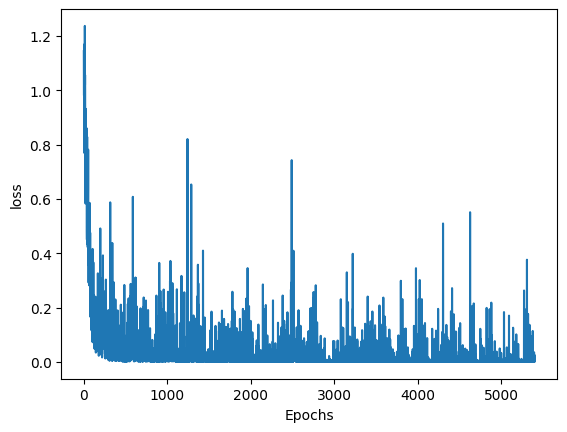

In [ ]:
plt.plot(range(len(train_loss)), train_loss)
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

Accuracy: 0.6479
Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      0.30      0.38        30
     Neutral       0.50      0.08      0.13        26
    Positive       0.67      0.94      0.78        86

    accuracy                           0.65       142
   macro avg       0.57      0.44      0.43       142
weighted avg       0.61      0.65      0.58       142



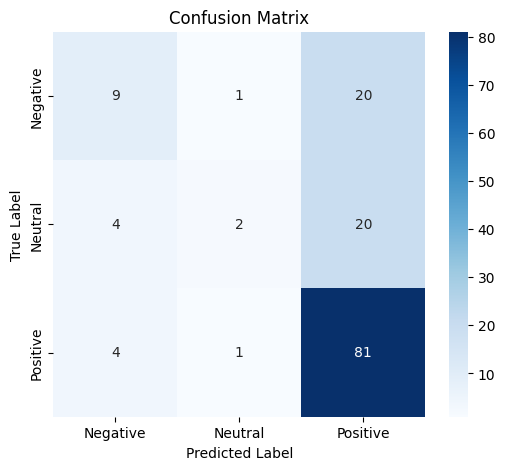

In [ ]:
y_test_true, y_test_pred = predict(model, test_loader)

# Compute accuracy
accuracy = accuracy_score(y_test_true, y_test_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Compute confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#### Training with K-Fold Cross Validation

In [ ]:
# Set parameters
batch_size = 32
k_folds = 7
epochs = 300

full_dataset = SentimentDataset(X, y)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store results
all_y_true = []
all_y_pred = []
accuracies = []
conf_matrices = []

# K-Fold Cross-Validation Loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔹 Fold {fold + 1}/{k_folds} 🔹")

    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    modelkfold = NeuralNet(X.shape[1])
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelkfold.parameters(), lr=0.002)

    # Train model
    train_model(modelkfold, train_loader, criterion, optimizer, epochs)

    # Get predictions
    y_test_true, y_test_pred = predict(modelkfold, test_loader)

    # Store predictions for final classification report
    all_y_true.extend(y_test_true)
    all_y_pred.extend(y_test_pred)

    # Compute accuracy for this fold
    fold_accuracy = accuracy_score(y_test_true, y_test_pred)
    accuracies.append(fold_accuracy)

    cm = confusion_matrix(y_test_true, y_test_pred)
    conf_matrices.append(cm)

    print(f"  Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")



🔹 Fold 1/7 🔹
Epoch 0, Loss: 0.803118884563446
Epoch 10, Loss: 0.12552469968795776
Epoch 20, Loss: 0.023218339309096336
Epoch 30, Loss: 0.23579971492290497
Epoch 40, Loss: 0.001690771896392107
Epoch 50, Loss: 0.19226931035518646
Epoch 60, Loss: 0.009946380741894245
Epoch 70, Loss: 0.008844987489283085
Epoch 80, Loss: 0.0026956673245877028
Epoch 90, Loss: 0.0008588497876189649
Epoch 100, Loss: 0.0008276564767584205
Epoch 110, Loss: 0.12941552698612213
Epoch 120, Loss: 0.0026349881663918495
Epoch 130, Loss: 0.008448313921689987
Epoch 140, Loss: 0.0009023150196298957
Epoch 150, Loss: 0.004395393189042807
Epoch 160, Loss: 0.002724915277212858
Epoch 170, Loss: 0.014135641977190971
Epoch 180, Loss: 0.0007049433188512921
Epoch 190, Loss: 0.00058885378530249
Epoch 200, Loss: 0.000139114199555479
Epoch 210, Loss: 0.0002726541133597493
Epoch 220, Loss: 0.0012835520319640636
Epoch 230, Loss: 0.0007605577702634037
Epoch 240, Loss: 0.0014811705332249403
Epoch 250, Loss: 0.0003885719343088567
Epoch 


✅ Average Accuracy Across 7 Folds: 0.5375
Classification Report:
              precision    recall  f1-score   support

    Negative       0.43      0.66      0.52       197
     Neutral       0.24      0.21      0.23        98
    Positive       0.72      0.55      0.63       412

    accuracy                           0.54       707
   macro avg       0.46      0.48      0.46       707
weighted avg       0.57      0.54      0.54       707



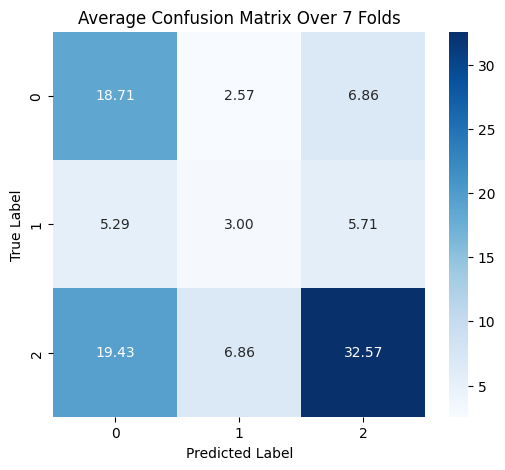

In [ ]:
# Compute average accuracy
avg_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy Across {k_folds} Folds: {avg_accuracy:.4f}")

print("Classification Report:")
print(classification_report(
    all_y_true, all_y_pred, target_names=['Negative', 'Neutral', 'Positive']
))

avg_cm = np.mean(conf_matrices, axis=0)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(avg_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Average Confusion Matrix Over {k_folds} Folds")
plt.show()

### Using GloVe Embeddings

#### Training with Simple Train-Test Split

In [ ]:
# DataLoader for training
batch_size = 32
dataset = SentimentDataset(X_glove, y)

# split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
torch.manual_seed(42)

model = NeuralNet(X_glove.shape[1]) # creating model
criterion = nn.CrossEntropyLoss() # defining loss

optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

epochs = 100

In [ ]:
train_loss = train_model(model, train_loader, criterion, optimizer, epochs=300)

Epoch 0, Loss: 0.8119693994522095
Epoch 10, Loss: 0.03225217014551163
Epoch 20, Loss: 0.03826829046010971
Epoch 30, Loss: 0.003399598877876997
Epoch 40, Loss: 0.0009642812656238675
Epoch 50, Loss: 0.4800069034099579
Epoch 60, Loss: 0.0027335279155522585
Epoch 70, Loss: 0.4702954590320587
Epoch 80, Loss: 0.0003865037579089403
Epoch 90, Loss: 0.000399043841753155
Epoch 100, Loss: 0.002558990614488721
Epoch 110, Loss: 0.004514101892709732
Epoch 120, Loss: 0.12547428905963898
Epoch 130, Loss: 0.4194166660308838
Epoch 140, Loss: 0.0035829029511660337
Epoch 150, Loss: 0.0014927488518878818
Epoch 160, Loss: 0.014358959160745144
Epoch 170, Loss: 0.0007997661014087498
Epoch 180, Loss: 3.4856358979595825e-05
Epoch 190, Loss: 0.0003377778921276331
Epoch 200, Loss: 0.0010931345168501139
Epoch 210, Loss: 0.0025250751059502363
Epoch 220, Loss: 0.02735280990600586
Epoch 230, Loss: 0.00014733168063685298
Epoch 240, Loss: 0.0011001302627846599
Epoch 250, Loss: 0.0004596303915604949
Epoch 260, Loss: 9.3

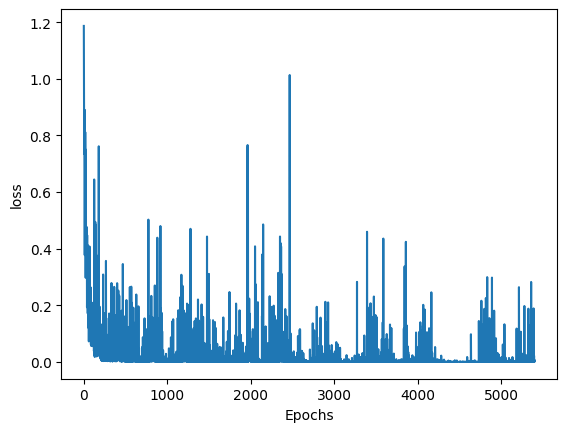

In [ ]:
plt.plot(range(len(train_loss)), train_loss)
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

Accuracy: 0.7676
Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      1.00      0.86        30
     Neutral       0.42      0.19      0.26        26
    Positive       0.82      0.86      0.84        86

    accuracy                           0.77       142
   macro avg       0.66      0.68      0.65       142
weighted avg       0.73      0.77      0.74       142



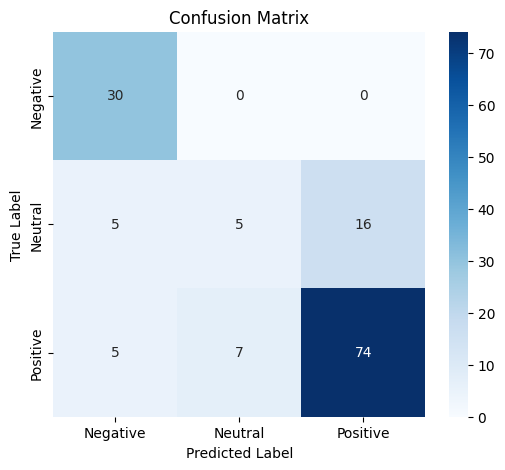

In [ ]:
y_test_true, y_test_pred = predict(model, test_loader)

# Compute accuracy
accuracy = accuracy_score(y_test_true, y_test_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Compute confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#### Training with K-Fold Cross Validation

In [ ]:
# Set parameters
batch_size = 32
k_folds = 7
epochs = 300

full_dataset = SentimentDataset(X_glove, y)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store results
all_y_true = []
all_y_pred = []
accuracies = []
conf_matrices = []

# K-Fold Cross-Validation Loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔹 Fold {fold + 1}/{k_folds} 🔹")

    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    modelkfold = NeuralNet(X_glove.shape[1])
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelkfold.parameters(), lr=0.002)

    # Train model
    train_model(modelkfold, train_loader, criterion, optimizer, epochs)

    # Get predictions
    y_test_true, y_test_pred = predict(modelkfold, test_loader)

    # Store predictions for final classification report
    all_y_true.extend(y_test_true)
    all_y_pred.extend(y_test_pred)

    # Compute accuracy for this fold
    fold_accuracy = accuracy_score(y_test_true, y_test_pred)
    accuracies.append(fold_accuracy)

    cm = confusion_matrix(y_test_true, y_test_pred)
    conf_matrices.append(cm)

    print(f"  Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")



🔹 Fold 1/7 🔹
Epoch 0, Loss: 0.598138153553009
Epoch 10, Loss: 0.14149154722690582
Epoch 20, Loss: 0.01867399737238884
Epoch 30, Loss: 0.07007158547639847
Epoch 40, Loss: 0.0029064191039651632
Epoch 50, Loss: 0.0022189305163919926
Epoch 60, Loss: 0.00036590435774996877
Epoch 70, Loss: 0.003247337182983756
Epoch 80, Loss: 0.013560694642364979
Epoch 90, Loss: 0.0012314808554947376
Epoch 100, Loss: 0.1324913203716278
Epoch 110, Loss: 0.0028069771360605955
Epoch 120, Loss: 0.1472652703523636
Epoch 130, Loss: 0.07553049176931381
Epoch 140, Loss: 0.0013097497867420316
Epoch 150, Loss: 0.002154387068003416
Epoch 160, Loss: 0.0005197335849516094
Epoch 170, Loss: 7.932521111797541e-05
Epoch 180, Loss: 0.0027768744621425867
Epoch 190, Loss: 0.07179954648017883
Epoch 200, Loss: 0.0007218064274638891
Epoch 210, Loss: 0.0003002774901688099
Epoch 220, Loss: 9.985496035369579e-06
Epoch 230, Loss: 0.0004901898792013526
Epoch 240, Loss: 0.0005641672178171575
Epoch 250, Loss: 5.2163137297611684e-05
Epoc


Average Accuracy Across 7 Folds: 0.7907
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.89      0.85       197
     Neutral       0.41      0.28      0.33        98
    Positive       0.84      0.86      0.85       412

    accuracy                           0.79       707
   macro avg       0.69      0.68      0.68       707
weighted avg       0.77      0.79      0.78       707



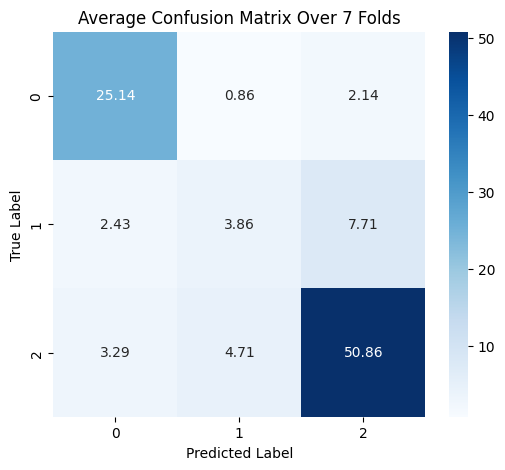

In [ ]:
# Compute average accuracy
avg_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy Across {k_folds} Folds: {avg_accuracy:.4f}")

print("Classification Report:")
print(classification_report(
    all_y_true, all_y_pred, target_names=['Negative', 'Neutral', 'Positive']
))

avg_cm = np.mean(conf_matrices, axis=0)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(avg_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Average Confusion Matrix Over {k_folds} Folds")
plt.show()